In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import scipy.io

%matplotlib inline

In [0]:
os.chdir('drive/My Drive/Dataset')

In [0]:
def Load_Data():
  
  data_set = scipy.io.loadmat('data.mat')
  train_set_X = data_set['X'].T
  train_set_Y = data_set['y']
  test_set_X = data_set['Xval'].T
  test_set_Y = data_set['yval']
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

(2, 211) (211, 1) (2, 200) (200, 1)


Text(0.5, 1.0, 'Ground Positions')

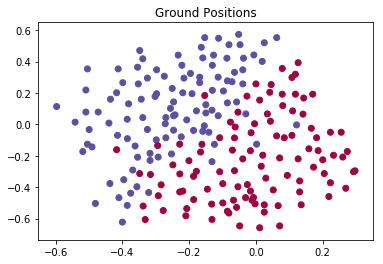

In [55]:
train_set_X,train_set_Y,test_set_X,test_set_Y = Load_Data()
print(train_set_X.shape,train_set_Y.shape,test_set_X.shape,test_set_Y.shape)
plt.scatter(train_set_X[0,:],train_set_X[1,:],c=train_set_Y[:,0],cmap=plt.cm.Spectral)
plt.title('Ground Positions')

In [0]:
def Create_Placeholder(shape1,shape2):
  
  X = tf.placeholder(name='X',dtype=tf.float32,shape=(shape1[0],None))
  Y = tf.placeholder(name='Y',dtype=tf.float32,shape=(None,shape2[1]))
  
  return X,Y

In [0]:
def Initialize_Parameters(layers_dims):
  
  L = len(layers_dims)
  parameters = {}
  
  for l in range(1,L):
    W = tf.get_variable(name="W"+str(l),shape=(layers_dims[l],layers_dims[l-1]),initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable(name="b"+str(l),shape=(layers_dims[l],1),initializer=tf.zeros_initializer())
    parameters['W'+str(l)] = W
    parameters['b'+str(l)] = b
    
  return parameters

In [0]:
def compute_cost_sigmoid(A,Y,parameters,regu,lambd,layers_dims):
  
  m_train = tf.cast(tf.shape(Y)[0],dtype=tf.float32)
  A = tf.transpose(A)
  cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=A,labels=Y))
  
  if(regu):
    L = len(layers_dims)
    sum = tf.Variable(0.0)
    
    for l in range(1,L):
      W = parameters['W'+str(l)]
      sum = tf.add(sum,tf.nn.l2_loss(W))
    sum = tf.divide(tf.multiply(sum,lambd),m_train)
    
    cost = tf.add(cost,sum)
  
  return cost

In [0]:
def compute_cost_softmax(A,Y,parameters,regu,lambd,layers_dims):
  
  m_train = tf.cast(tf.shape(Y)[0],dtype=tf.float32)
  A = tf.transpose(A)
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=A,labels=Y))
  
  if(regu):
    L = len(layers_dims)
    sum = tf.Variable(0.0)
    
    for l in range(1,L):
      W = parameters['W'+str(l)]
      sum = tf.add(sum,tf.nn.l2_loss(W))
    sum = tf.divide(tf.multiply(sum,lambd),m_train)
    
    cost = tf.add(cost,sum)
  
  return cost

In [0]:
def Forward_Propagation(X,parameters,regu,lambd,keep_prob,layers_dims):
  
  L = len(layers_dims)
  A_prev = X
  
  for l in range(1,L):
    
    activation = 'relu'
    W = parameters['W'+str(l)]
    b = parameters['b'+str(l)]
    Z = tf.add(tf.matmul(W,A_prev),b)
    ZNorm = tf.transpose(tf.layers.batch_normalization(tf.transpose(Z),axis=-1,epsilon=0.001,center=True,scale=True,beta_initializer=tf.zeros_initializer(),gamma_initializer=tf.contrib.layers.xavier_initializer()))
    if(l != L-1):
      A = tf.nn.relu(ZNorm)
    else:
      A = ZNorm
    A_prev = tf.nn.dropout(A,rate=1-keep_prob[l-1])
    
  return A_prev

In [0]:
def Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size):
  
  m_train = train_set_X.shape[1]
  perm = list(np.random.permutation(m_train))
  train_set_X = train_set_X[:,perm]
  train_set_Y = train_set_Y[perm,:]
  
  n = int(m_train/mini_batch_size)
  minibatches = []
  
  for i in range(n):
    X = train_set_X[:,i*mini_batch_size:(i+1)*mini_batch_size]
    Y = train_set_Y[i*mini_batch_size:(i+1)*mini_batch_size,:]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  if(m_train % mini_batch_size != 0):
    X = train_set_X[:,n*mini_batch_size:m_train]
    Y = train_set_Y[n*mini_batch_size:m_train,:]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  return minibatches

In [0]:
def Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,layers_dims,regu,lambd,keep_prob,mini_batch_size):
  
  L = len(layers_dims)
  
  if(layers_dims[L-1] > 1):
    activation = 'softmax'
    train_set_Y = np.eye(layers_dims[L-1])[train_set_Y.T][0]
    test_set_Y = np.eye(layers_dims[L-1])[test_set_Y.T][0]
  else:
    activation = 'sigmoid'
  
  X,Y = Create_Placeholder(train_set_X.shape,train_set_Y.shape)
  parameters = Initialize_Parameters(layers_dims)
  A = Forward_Propagation(X,parameters,regu,lambd,keep_prob,layers_dims)
  
  if(activation == 'softmax'):
    cost = compute_cost_softmax(A,Y,parameters,regu,lambd,layers_dims)
  else:
    cost = compute_cost_sigmoid(A,Y,parameters,regu,lambd,layers_dims)
  
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
  
  init = tf.global_variables_initializer()
  total_cost = []
  
  sess = tf.Session()
  sess.run(init)
  
  for i in range(epochs):
    minibatches = Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size)
    
    for minibatch in minibatches:
      (minibatch_X,minibatch_Y) = minibatch
      val1,val2 = sess.run([cost,optimizer],feed_dict={X:minibatch_X,Y:minibatch_Y})
      
      if(i%10 == 0):
        total_cost.append(val1)
    
    if(i%10 == 0):
      print('Cost after '+str(i)+'th Iteration : '+str(val1))
    
  plt.plot(total_cost)
  plt.xlabel('Iterations')
  plt.ylabel('Cost')
  plt.title("Learning_Rate : "+str(learning_rate))
  plt.show()  
  
  if(activation == 'sigmoid'):
    A_val = tf.sigmoid(A)
    ans = tf.ceil(A_val-0.5)
    Acc = tf.reduce_mean(tf.multiply(ans,Y))*100
  
  else:
    A_val = tf.nn.softmax(A)
    ans = tf.transpose(A_val)
    A_corr = tf.cast(tf.equal(tf.argmax(ans,axis=1),tf.argmax(Y,axis=1)),'float')
    Acc = tf.reduce_mean(A_corr)*100
    
  print("Training Set Accuracy  :  ",sess.run(Acc,feed_dict={X:train_set_X,Y:train_set_Y})) 
  print("Test Set Accuracy  :  ",sess.run(Acc,feed_dict={X:test_set_X,Y:test_set_Y}))
  
  parameters = sess.run(parameters)
  
  sess.close()
  
  return parameters  

In [0]:
def Caller_Function():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y = Load_Data()
  learning_rate = 0.001
  epochs = 1000
  layers_dims = [train_set_X.shape[0]]
  layers_dims.extend([10000,20,4,2])
  mini_batch_size = 211
  regu = False
  lambd = 0.01
  keep_prob = [0.8,1,1,1]
  parameters = Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,layers_dims,regu,lambd,keep_prob,mini_batch_size)
  
  print('')
  for key,value in parameters.items():
    print(key,value)

Cost after 0th Iteration : 0.69314784
Cost after 10th Iteration : 0.6931305
Cost after 20th Iteration : 0.69310033
Cost after 30th Iteration : 0.69284016
Cost after 40th Iteration : 0.69166523
Cost after 50th Iteration : 0.68747765
Cost after 60th Iteration : 0.674476
Cost after 70th Iteration : 0.6402303
Cost after 80th Iteration : 0.5680341
Cost after 90th Iteration : 0.45432073
Cost after 100th Iteration : 0.34783274
Cost after 110th Iteration : 0.2916075
Cost after 120th Iteration : 0.26115957
Cost after 130th Iteration : 0.23704611
Cost after 140th Iteration : 0.2339927
Cost after 150th Iteration : 0.23521675
Cost after 160th Iteration : 0.22806776
Cost after 170th Iteration : 0.23299041
Cost after 180th Iteration : 0.23239078
Cost after 190th Iteration : 0.2417584
Cost after 200th Iteration : 0.23551789
Cost after 210th Iteration : 0.23542547
Cost after 220th Iteration : 0.23156224
Cost after 230th Iteration : 0.23362043
Cost after 240th Iteration : 0.23340133
Cost after 250th It

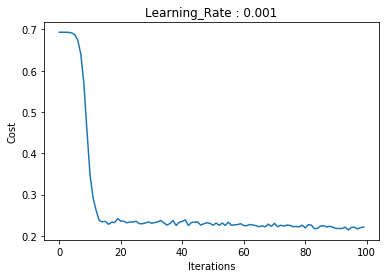

Training Set Accuracy  :   79.62086
Test Set Accuracy  :   73.5

W1 [[ 0.13007508 -0.04203643]
 [-0.00233962 -0.01964043]
 [-0.01134768 -0.01158256]
 ...
 [ 0.01032735  0.00246195]
 [ 0.01718518 -0.01750965]
 [ 0.00486165 -0.00096776]]
b1 [[ 0.06696281]
 [ 0.00204672]
 [-0.00024504]
 ...
 [-0.00025103]
 [ 0.002517  ]
 [ 0.00297018]]
W2 [[ 0.00916826  0.00843606  0.01178486 ... -0.00696271 -0.00415047
   0.00113544]
 [-0.06822574 -0.0102917   0.00245491 ...  0.01760214 -0.00349883
  -0.01117167]
 [ 0.18630984  0.00761814 -0.02231562 ... -0.01906563  0.02268236
  -0.00931547]
 ...
 [-0.04481992  0.01555813 -0.01212596 ... -0.00843024 -0.02307617
  -0.00860785]
 [ 0.01471151 -0.01346951 -0.00762655 ... -0.02219948 -0.00823197
   0.01433052]
 [-0.10626061  0.0108361   0.0152073  ... -0.01766056  0.01321223
  -0.01332104]]
b2 [[-0.00361375]
 [-0.09568765]
 [ 0.13442148]
 [ 0.09716092]
 [-0.00600505]
 [-0.0060048 ]
 [ 0.10751084]
 [-0.08435656]
 [-0.0060029 ]
 [ 0.10563532]
 [ 0.00514263]
 [

In [113]:
tf.reset_default_graph()
Caller_Function()